In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [2]:
df = pd.read_excel('RJ_Reconstrucao_Moluscos_2024_06_06.xlsx')
print(df.head())

    Ano  Lula_art  Lula_ind  Lula_art_ind  Lula_oceanica_art  Calamar_ind  \
0  1950       NaN       NaN           NaN                NaN          NaN   
1  1951       NaN       NaN           NaN                NaN          NaN   
2  1952       NaN       NaN           NaN                NaN          NaN   
3  1953       NaN       NaN           NaN                NaN          NaN   
4  1954       NaN       NaN           NaN                NaN          NaN   

   Polvo_art  Polvo_ind  Polvo_art_ind  Polvo_cabecinha_art  ...  \
0        NaN        NaN            NaN                  NaN  ...   
1        NaN        NaN            NaN                  NaN  ...   
2        NaN        NaN            NaN                  NaN  ...   
3        NaN        NaN            NaN                  NaN  ...   
4        NaN        NaN            NaN                  NaN  ...   

   Mexilhao_art  Mexilhao_ind  Mexilhao_mangue_art  Caramujo_art  \
0           NaN           NaN                  NaN          

In [3]:
x0 = df[['Ano', 'Polvo_art']].dropna().values
x1 = df[['Ano', 'Polvo_ind']].dropna().values


In [4]:
df_x0= pd.DataFrame(x0, columns= ['Ano', 'Polvo_art'])
df_x1=pd.DataFrame(x1, columns= ['Ano', 'Polvo_ind'])
df_x0= df_x0.drop_duplicates(subset= 'Polvo_art')
df_x1= df_x1.drop_duplicates(subset='Polvo_ind')

In [5]:
x = np.array(df_x0['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x0['Polvo_art'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

In [6]:
def leaky_relu(x):
    return tf.nn.RMSprop(x, alpha=0.01)

Epoch 1/1000


C:\Users\Renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 173us/step - loss: 0.5100 - mse: 1.0001
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 102us/step - loss: 0.5077 - mse: 0.9955
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - loss: 0.5045 - mse: 0.9891
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 92us/step - loss: 0.5018 - mse: 0.9839
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - loss: 0.4991 - mse: 0.9787
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 83us/step - loss: 0.4971 - mse: 0.9747
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - loss: 0.4951 - mse: 0.9708


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - loss: 0.4931 - mse: 0.9670
Epoch 9/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4917 - mse: 0.9642
Epoch 10/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - loss: 0.4901 - mse: 0.9610
Epoch 11/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4886 - mse: 0.9581
Epoch 12/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 74us/step - loss: 0.4874 - mse: 0.9556
Epoch 13/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 72us/step - loss: 0.4858 - mse: 0.9525
Epoch 14/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 83us/step - loss: 0.4844 - mse: 0.9498
Epoch 15/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4827 - mse: 0.9466
Epoch 16/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - loss: 0.4807 - mse: 0.9425
Epoch 17/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - loss: 0.4786 - mse: 0.9385
Epoch 18/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - loss: 0.4765 - mse: 0.9343
Epoch 19/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 73us/step - loss: 0.4741 - mse: 0.9297
Epoch 

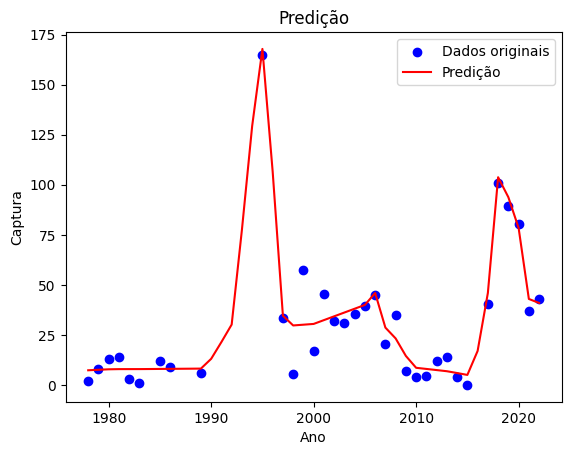

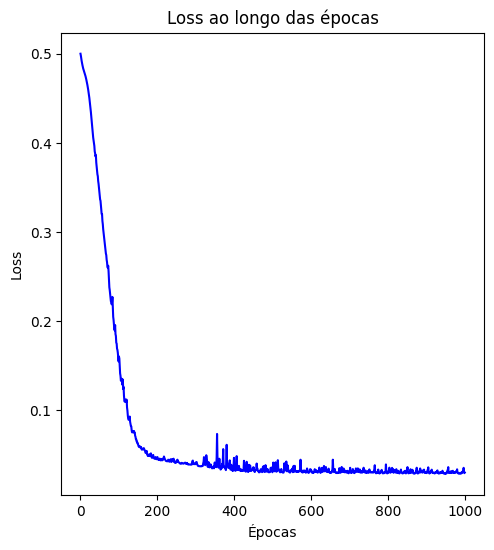

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])


history = model.fit(x_normalized, y_normalized, epochs= 1000, batch_size= 64, steps_per_epoch= 50, verbose=True)

x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predição para o ano 1969: 5.117504119873047
Predição para o ano 1970: 5.395412445068359
Predição para o ano 1971: 5.682249069213867
Predição para o ano 1972: 5.920269012451172
Predição para o ano 1973: 6.15827751159668
Predição para o ano 1974: 6.396324157714844
Predição para o ano 1975: 6.634347915649414
Predição para o ano 1976: 6.865240097045898
Predição para o ano 1977: 7.0978851318359375
Predição para o ano 1990: 13.052019119262695
Predição para o ano 1991: 21.434856414794922
Predição para o ano 1992: 30.162525177001953
Predição para o ano 1993: 77.50367736816406
Predição para o ano 1994: 129.34730529785156
Predição para o ano 2016: 16.982208251953125


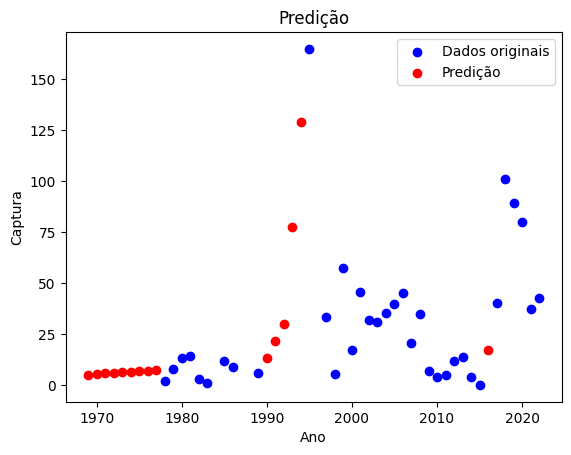

In [10]:
anos_para_prever = np.array([1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1990, 1991, 1992, 1993, 1994, 2016]).reshape(-1, 1)
anos_para_prever_normalizados = (anos_para_prever - x_mean) / x_std
predicoes_normalizadas = model.predict(anos_para_prever_normalizados)
predicoes = predicoes_normalizadas * y_std + y_mean


for ano, predicao in zip(anos_para_prever.flatten(), predicoes.flatten()):
    print(f"Predição para o ano {ano}: {predicao}")


df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='outer').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.scatter(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição')
plt.legend()
plt.show()

In [11]:
df_originais = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_preditos = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.merge(df_originais, df_preditos, on='Ano', how='outer').sort_values(by='Ano')
print(df_combined)
df_combined.to_excel('DataFrame_reconstruido/Polvo_artesanal_reconstruido.xlsx', index=False)

       Ano  Captura Original  Captura Preditos
0   1969.0               NaN          5.117504
1   1970.0               NaN          5.395412
2   1971.0               NaN          5.682249
3   1972.0               NaN          5.920269
4   1973.0               NaN          6.158278
5   1974.0               NaN          6.396324
6   1975.0               NaN          6.634348
7   1976.0               NaN          6.865240
8   1977.0               NaN          7.097885
9   1978.0          2.000000               NaN
10  1979.0          8.000000               NaN
11  1980.0         13.000000               NaN
12  1981.0         14.000000               NaN
13  1982.0          3.000000               NaN
14  1983.0          1.000000               NaN
15  1985.0         12.000000               NaN
16  1986.0          9.000000               NaN
17  1989.0          6.000000               NaN
18  1990.0               NaN         13.052019
19  1991.0               NaN         21.434856
20  1992.0   

POLVO INDUSTRIAL

In [13]:
x = np.array(df_x1['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x1['Polvo_ind'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

Epoch 1/250


C:\Users\Renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 171us/step - loss: 0.5353 - mse: 1.0497
Epoch 2/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.5217 - mse: 1.0229
Epoch 3/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - loss: 0.5108 - mse: 1.0016
Epoch 4/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - loss: 0.5076 - mse: 0.9953
Epoch 5/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - loss: 0.5063 - mse: 0.9927
Epoch 6/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - loss: 0.5051 - mse: 0.9903
Epoch 7/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 0.5038 - mse: 0.9878
Epoch 8/250


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.5026 - mse: 0.9855
Epoch 9/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.5015 - mse: 0.9832
Epoch 10/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - loss: 0.5002 - mse: 0.9808
Epoch 11/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4989 - mse: 0.9783
Epoch 12/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 73us/step - loss: 0.4975 - mse: 0.9755
Epoch 13/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4959 - mse: 0.9723
Epoch 14/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - loss: 0.4941 - mse: 0.9689
Epoch 15/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - loss: 0.4922 - mse: 0.9650
Epoch 16/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - loss: 0.4899 - mse: 0.9606
Epoch 17/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 0.4874 - mse: 0.9556
Epoch 18/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4845 - mse: 0.9501
Epoch 19/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 92us/step - loss: 0.4814 - mse: 0.9439
Epoch 20/250
50/50 ━━━━━━━━━━

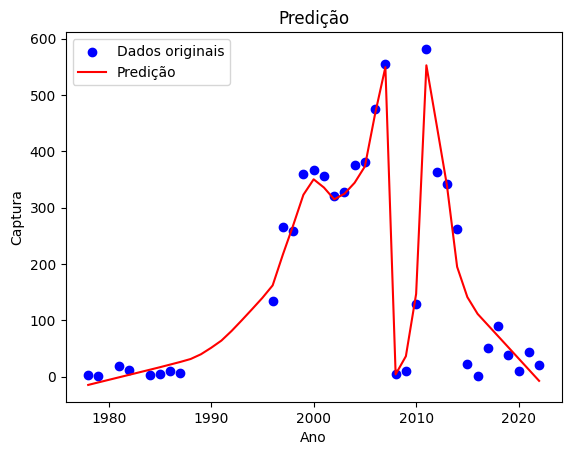

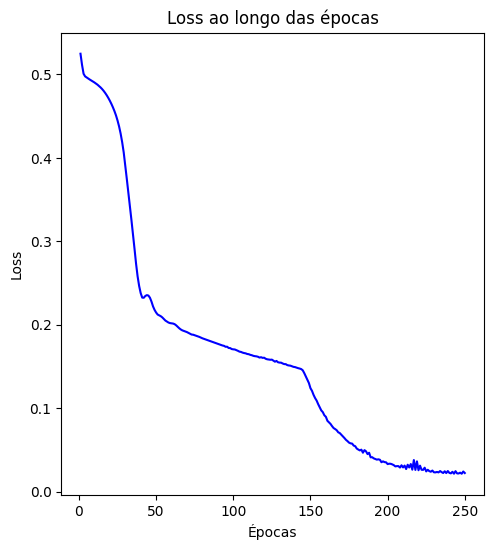

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])


history = model.fit(x_normalized, y_normalized, epochs= 250, batch_size= 64, steps_per_epoch= 50, verbose=True)

x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predição para o ano 1969: -64.67489624023438
Predição para o ano 1970: -59.0140380859375
Predição para o ano 1971: -53.35316467285156
Predição para o ano 1972: -47.69233703613281
Predição para o ano 1973: -42.031494140625
Predição para o ano 1974: -36.37066650390625
Predição para o ano 1975: -30.715835571289062
Predição para o ano 1976: -25.212509155273438
Predição para o ano 1977: -19.741989135742188
Predição para o ano 1983: 7.95819091796875
Predição para o ano 1990: 51.46257019042969
Predição para o ano 1991: 64.2176284790039
Predição para o ano 1992: 81.45266723632812
Predição para o ano 1993: 100.50599670410156
Predição para o ano 1994: 120.11019134521484
Predição para o ano 1995: 140.06480407714844


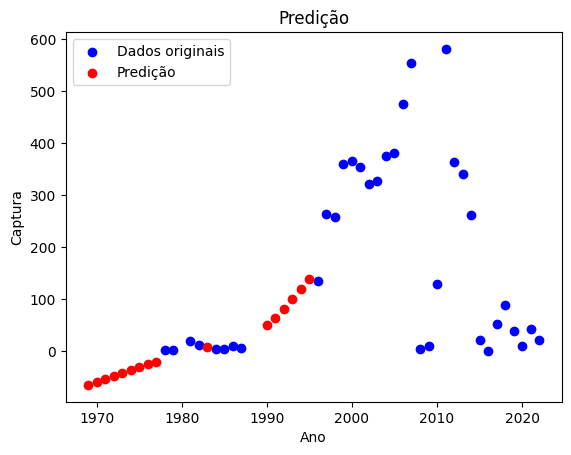

In [24]:
anos_para_prever = np.array([1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1983, 1990, 1991, 1992, 1993, 1994, 1995]).reshape(-1, 1)
anos_para_prever_normalizados = (anos_para_prever - x_mean) / x_std
predicoes_normalizadas = model.predict(anos_para_prever_normalizados)
predicoes = predicoes_normalizadas * y_std + y_mean


for ano, predicao in zip(anos_para_prever.flatten(), predicoes.flatten()):
    print(f"Predição para o ano {ano}: {predicao}")


df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='outer').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.scatter(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição')
plt.legend()
plt.show()